<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/01_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. イントロダクション
* キャメロン・デビッドソン=ピロン(著), 玉木徹(訳)：『Pythonで体験するベイズ推論:PyMCによるMCMC入門』, 森北出版 (2017)
 * https://www.amazon.co.jp/dp/4627077912
* 今回の授業資料で参考にしたコード（上の本の公式のリポジトリから）
 * https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb

## 1.1 はじめに
* 参考書を参照。

## 1.2 ベイズ推論の枠組み

### 1.2.A ベイズ則の復習

* $P(A|X)=\frac{P(X|A)P(A)}{P(X)}$
 * 証明には、条件付き確率の定義を使えばよい。

* $P(A|X) \propto P(X|A)P(A)$
 * こういう書き方をすることもある。

### 1.2.2 例題：司書か農業家か？
* 問題設定
 * スティーブは内向的な性格。彼が司書になりそうだという結論には、多くの人が同意するだろう。
 * だが、司書と農業家の比率は1:20で、農業家の方が司書より20倍多い。
---

* スティーブが司書であるという事象を$A$とする。スティーブについて何の情報もなければ、$P(A)=\frac{1}{21}=0.047$である。
 * これが事前確率である。
---

* 近所の住人から、彼が内向的だとの情報（この情報を$X$とする）を得た。考えたいのは$P(A|X)$である。
 * これが事後確率である。
---
ベイズ則：　$P(A|X)=\frac{P(X|A)P(A)}{P(X)}$
* $P(X|A)$について
 * $P(X|A)$はスティーブが司書である場合に近所の住人が彼は内向的だと語る確率。これは非常に高いだろう。
 * そこで、0.95とする。
* $P(X)$について
 * $P(X)=P(X|A)P(A)+P(X|\neg A)P(\neg A)$と分解できる。
 * $P(X|\neg A)$はスティーブが農業家である場合に近所の人が彼は内向的だと語る確率。0.5だとしよう。
 * すると、
$P(X)=0.95 \times \frac{1}{21} + 0.5 \times \frac{20}{21} = 0.52$を得る。
* 以上より、
$P(A|X) = \frac{0.95 \times \frac{1}{21}}{0.52} = 0.087$という結果を得る。


In [1]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

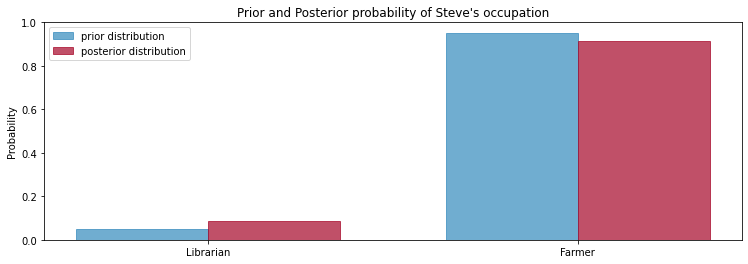

In [2]:
figsize(12.5, 4)
colours = ["#348ABD", "#A60628"]

LEFT = 0.0
RIGHT = 0.7
WIDTH = 0.25

prior = [1/21, 20/21]
posterior = [0.087, 1 - 0.087]
plt.bar([LEFT, RIGHT], prior, alpha=0.70, width=WIDTH,
        color=colours[0], label="prior distribution",
        lw="1", edgecolor=colours[0])

plt.bar([LEFT+WIDTH, RIGHT+WIDTH], posterior, alpha=0.7,
        width=WIDTH, color=colours[1],
        label="posterior distribution",
        lw="1", edgecolor=colours[1])

plt.xticks([LEFT+WIDTH/2, RIGHT+WIDTH/2], ["Librarian", "Farmer"])
plt.title("Prior and Posterior probability of Steve's occupation")
plt.ylabel("Probability")
plt.legend(loc="upper left")

### 1.2.B ベイズ的なデータ・モデリングにおけるベイズ則の使われ方
* ベイズ的なデータモデリングでは、$A$は確率分布のパラメータ、$X$は観測されたデータである。
 * $X$はすでに分かっているものである。
 * $A$は我々が直接知ることができないものである。
---
* $P(A)$はモデルのパラメータが従う確率分布で、事前分布(prior distribution)と呼ばれる。
* $P(X|A)$は観測データの尤度(likelihood)。
* $P(X)$は観測データの周辺尤度（marginal likelihood, evidence）。
* $P(A|X)$もモデルのパラメータが従う確率分布で、事後分布と呼ばれる。
---
* データのモデリングに使われる確率分布のパラメータについて、それが従う分布を考えるのがベイズ的なモデリングの特徴。
 * 分布の分布を考えるのがベイズ的なモデリングの特徴。
 * 例えば、最尤推定では「$P(X|A)$を最大にする$A$は何か？」という問題を解くことで答えを一つに決める。

### 1.2.1 例題：誰もが一度は通る「コイン投げ」問題
* 表が出た回数のモデリングには二項分布を使う。
 * これが$P(X|A)$に相当する。
* 二項分布のパラメータが従う分布としては、二項分布の共役事前分布であるベータ分布を使う。
 * これが$P(A)$に相当する。
* 求めたいのは、観測データが与えられているという条件の下で、表が出る確率が従う分布
 * これが$P(A|X)$に相当する。

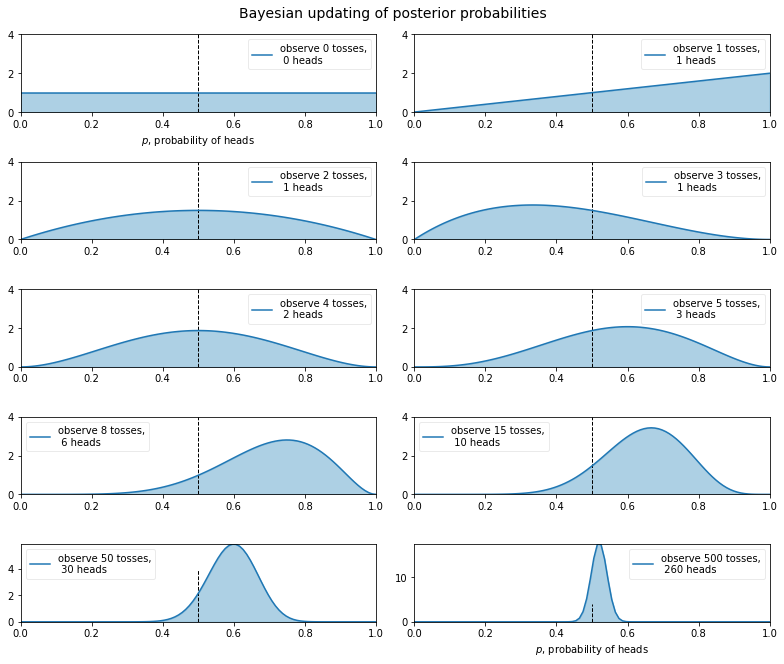

In [3]:
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta # ベータ分布
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500] # 試行回数
data = stats.bernoulli.rvs(0.5, size=n_trials[-1]) # 観測データを作る（表が出る確率0.5でコインをsize回投げておく）

x = np.linspace(0, 1, 100) 

# 二項分布にとって共役な事前分布であるベータ分布を使っている
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)/2, 2, k+1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials)-1] else None
    #plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum() # 観測データの最初のN個だけを事後分布のパラメータの計算に反映させる
    y = dist.pdf(x, 1 + heads, 1 + N - heads) # ベータ分布の確率密度関数を作る
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads)) # 密度関数の描画
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()

## 1.3 確率分布
* ベイズ的なデータモデリングを行うためには様々な確率分布についての知識が必要。
* データに合わせて、また、データをモデル化する分布に合わせて、適切な分布を選ぶ。

### 1.3.1 離散分布
* 確率変数$Z$のとる値が離散値の場合。
* 確率変数$Z$が特定の値をとる確率は、確率質量関数(pmf; probability mass function)によって与えられる。


* 例：ポアソン分布
$$P(Z = k; \lambda) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots $$
 * 確率変数$Z$がパラメータ$\lambda$のポアソン分布に従うことを、以下のように書く。
$$ Z \sim \mbox{Poi}(\lambda)$$
 * $Z$の期待値は$\lambda$になる。つまり、
$$\mathbb{E}_{P(Z;\lambda)}[Z] = \sum_{k=0}^\infty \bigg( k \frac{ \lambda^k e^{-\lambda} }{k!} \bigg) = \lambda$$


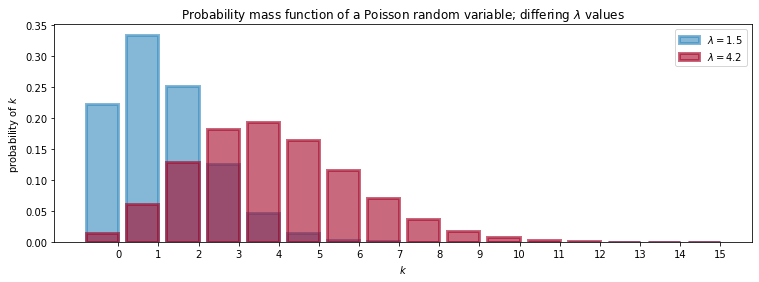

In [4]:
figsize(12.5, 4)

import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson # ポアソン分布
lambda_ = [1.5, 4.25] # パラメータλについて2通りの設定を考える
colours = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
        label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
        edgecolor=colours[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
        label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing $\lambda$ values");

### 1.3.2 連続分布
* 確率変数$Z$のとる値が連続値の場合。
* 連続な確率分布は、確率密度関数(pdf; probability density function)で表される。
 * 確率質量関数とは、全く別物。
* 例：指数分布
$$ f_Z(z; \lambda) = \lambda e^{ - \lambda z}, \; \; z \geq 0$$
 * $Z$がとる特定の値$z$について、$f_Z(z|\lambda)$は$Z=z$となる<u>確率を表すのではない</u>ことに注意！
 * $Z$がパラメータ$\lambda$の指数分布に従うことを、以下のように書く。
$$ Z \sim \mbox{Exp}(\lambda) $$
 * $Z$の期待値は$\frac{1}{\lambda}$となる。つまり、
$$ \mbox{E}_{f_Z(z;\lambda)}[Z] = \int_0^\infty z \lambda e^{ - \lambda z} dz = \frac{1}{\lambda}$$

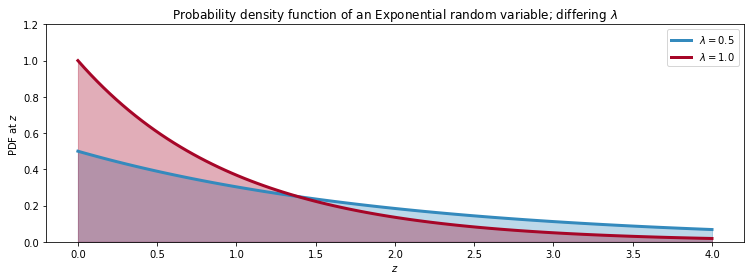

In [5]:
a = np.linspace(0, 4, 100)
expo = stats.expon # 指数分布
lambda_ = [0.5, 1] # パラメータλについて2通りの設定を考える

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an Exponential random variable; differing $\lambda$");

## 1.4 コンピュータにベイズ推論をさせるには

### 1.4.1 例題：メッセージ数に変化はあるか？
* あるユーザが毎日受信するメッセージ数（参考書のデータをそのまま使う）。
 * 73件の実数値データ（実際には全て整数値）

In [6]:
!wget "https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv"

--2021-03-04 09:01:01--  https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1850 (1.8K) [text/plain]
Saving to: ‘txtdata.csv.3’

txtdata.csv.3       100%[===================>]   1.81K  --.-KB/s    in 0s      

2021-03-04 09:01:01 (34.2 MB/s) - ‘txtdata.csv.3’ saved [1850/1850]



* 知りたいのは、時間が経つにつれて受信数が変化しているかどうか。
* 受信数をどのようにモデリングすれば良いだろうか？

(0.0, 74.0)

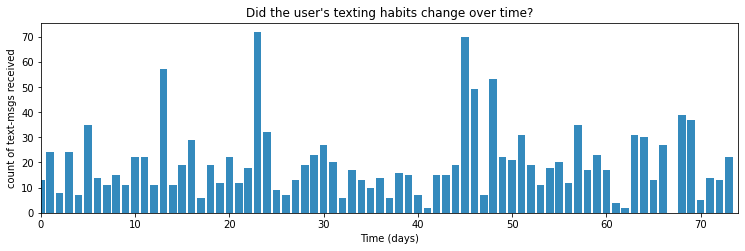

In [7]:
PATH = 'txtdata.csv'

figsize(12.5, 3.5)
count_data = np.loadtxt(PATH)
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

* 見た感じ、時間軸の真ん中あたりを境に、後半は受信数が多めに見える。
* そこで、ある変化点$\tau$を境に、受信数が異なる分布に従うと仮定する。
 * $\tau$より前は、パラメータが$\lambda_1$のポアソン分布に従い、
 * $\tau$以後は、パラメータが$\lambda_2$のポアソン分布に従うと仮定する。

* $\lambda_1$と$\lambda_2$は、同じ事前分布に従うと仮定する。
 * いずれも、パラメータが$\alpha$の指数分布に従うと仮定する。

* 境界となる時点$\tau$については、考えている時間軸の範囲のどの位置になるかが等確率であると仮定する。
 * 考えている時間軸の範囲にある時点の個数を$N$とする。
 * $\tau$は、以下の確率質量関数を持つ一様分布に従うと仮定する。
$$ P(\tau = k) = \frac{1}{N} $$

* 以上でデータのモデルは決まった。
* このモデルを「データにフィットさせ」て$\lambda_1$や$\lambda_2$の事後分布や、変化点$\tau$の事後分布を求めるには、どうすればいいか？
 * これを分かるようになるのが、「統計モデリング2」の前半の目標。 
 * ツールとしては、PyMCを使うことにする。

### 1.4.2 必殺の一撃：PyMC
* ここからの説明は、とりあえずは、なんとなく聞くだけで良いです。
 * PyMC3の公式サイト https://docs.pymc.io/

* arvizというツールを使うためにPyMC3のバージョンを3.8に上げる。

In [8]:
!pip install pymc3==3.8

In [9]:
import pymc3 as pm

In [10]:
model = pm.Model()

In [11]:
with model:
    alpha = 1.0 / count_data.mean() # 受信数の平均の逆数
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [12]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [13]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [14]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling chain 1, 0 divergences: 100%|██████████| 15000/15000 [00:06<00:00, 2310.96it/s]
The number of effective samples is smaller than 25% for some parameters.


In [15]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

Text(0, 0.5, 'probability')

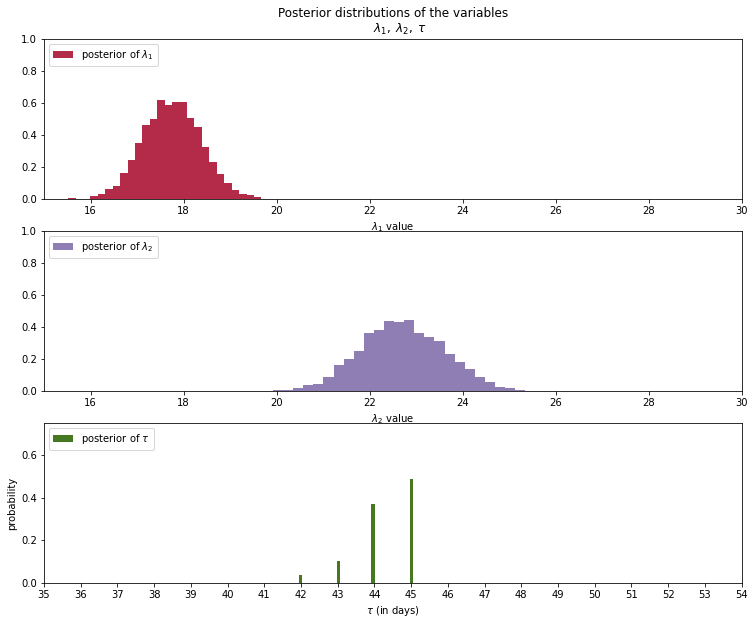

In [16]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")

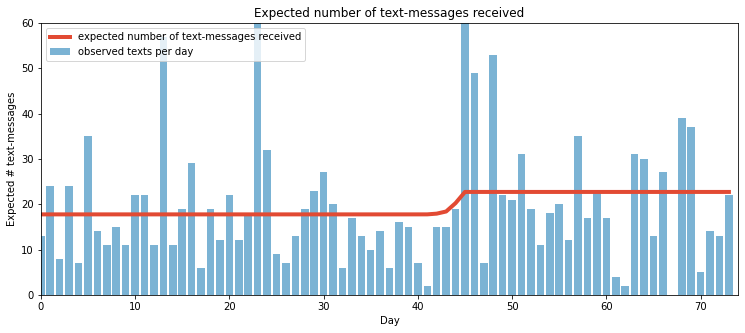

In [17]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")

In [19]:
!pip install arviz

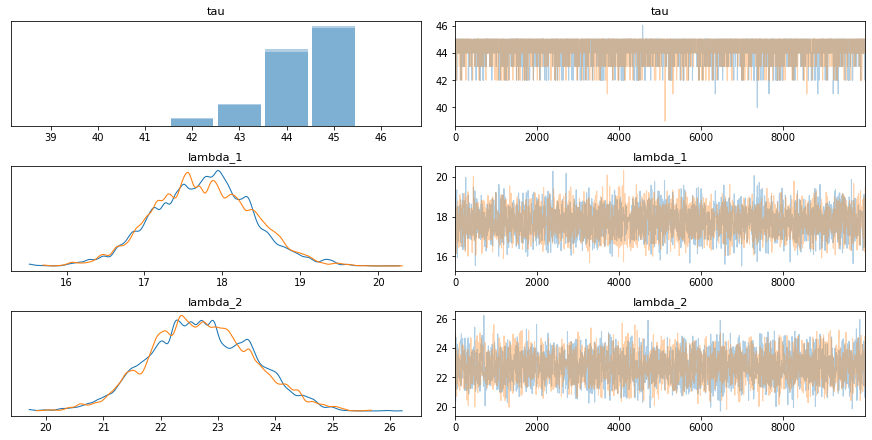

In [20]:
import arviz as az
with model:
    az.plot_trace(trace)

In [21]:
with model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau,44.31,0.81,43.00,45.00,0.02,0.01,2886.62,2886.62,2926.51,3432.02,1.0
lambda_1,17.75,0.63,16.60,18.92,0.01,0.01,3716.89,3716.89,3723.65,4230.40,1.0
lambda_2,22.71,0.89,21.17,24.48,0.02,0.01,3439.60,3439.60,3450.68,4021.93,1.0


## 課題1
* ポアソン分布$\mbox{Poi}(\lambda)$に従う確率変数の期待値が$\lambda$になることを示せ。
* 指数分布$\mbox{Exp}(\lambda)$に従う確率変数の期待値が$\frac{1}{\lambda}$になることを示せ。
 * 分からない場合は、ググって調べましょう。